In [1]:
# ============================
# Step 1: Unzip Dataset
# ============================

import zipfile
import os

# TODO: Set the correct uploaded ZIP filename
zip_path = 'dataset.zip' # <-- replace with the exact uploaded filename
extract_path = './dataset' # folder where you want to extract

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"✅ Unzipped to: {os.path.abspath(extract_path)}")

# Optional: List the extracted folder contents
print("Contents:")
print(os.listdir(extract_path))

✅ Unzipped to: /mnt/nfs/work/david97099/Github/ML-Labs/Labs8/dataset
Contents:
['pitted_surface', 'rolled-in_scale', 'scratches', 'crazing', 'inclusion', 'patches']


In [2]:
# ============================
# Step 2: Split Dataset into Train/Test
# ============================

import shutil
import random

# TODO: Set source folder (where unzipped dataset is) and target folder (where split dataset will go)
SOURCE_DIR = 'dataset' # folder from unzip
TARGET_DIR = 'dataset_split' # new folder to store split data

# Split ratios
train_ratio = 0.7
test_ratio = 0.3 # note: you can calculate this as 1 - train_ratio if needed

# Set random seed for reproducibility
random.seed(42)

# Create target train/test directories per class
for split in ['train', 'test']:
    for class_name in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(TARGET_DIR, split, class_name), exist_ok=True)
        
# Process each class folder
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
        
    images = os.listdir(class_path)
    random.shuffle(images)
        
    # Calculate split point
    train_cutoff = int(len(images) * train_ratio)

    # Split images
    train_images = images[:train_cutoff]
    test_images = images[train_cutoff:]

    # Copy training images
    for img_name in train_images:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(TARGET_DIR, 'train', class_name, img_name)
        shutil.copyfile(src, dst)

    # Copy testing images
    for img_name in test_images:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(TARGET_DIR, 'test', class_name, img_name)
        shutil.copyfile(src, dst)
print("✅ Dataset split complete!")

✅ Dataset split complete!


Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Train samples: 1260
Test samples: 540


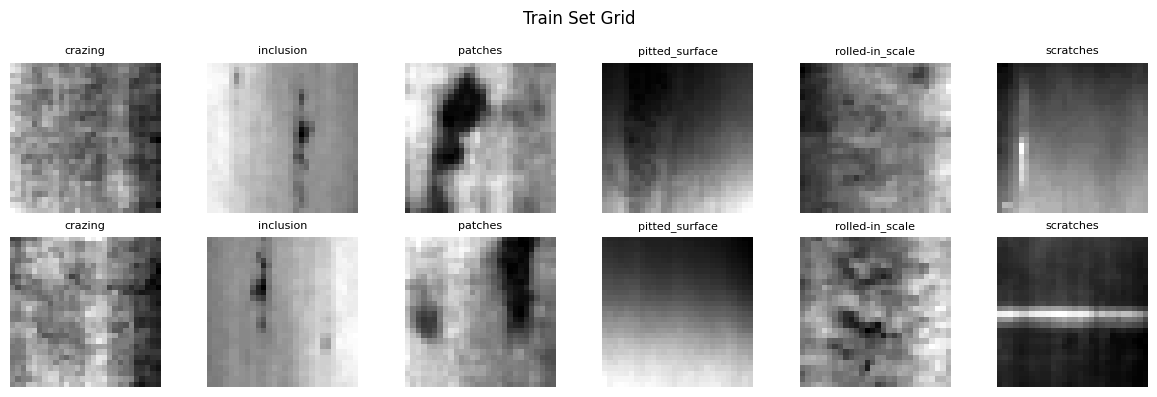

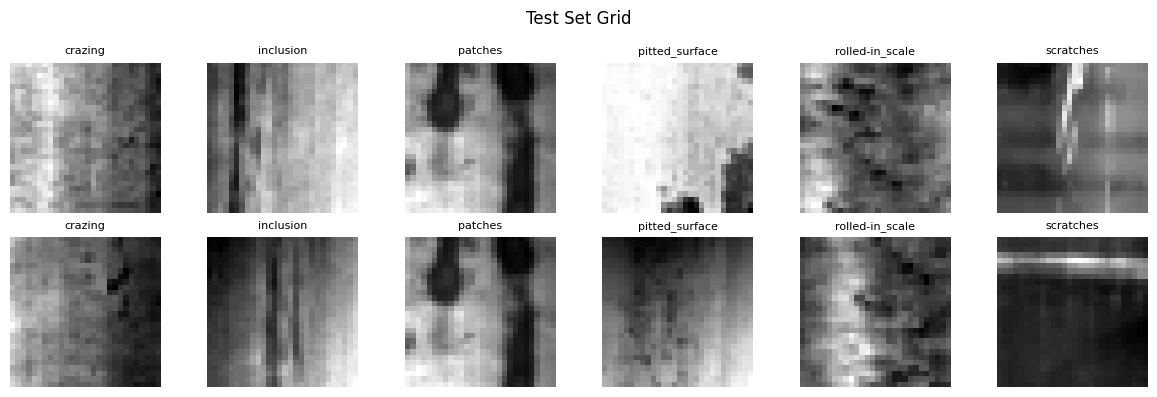

In [3]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set dataset paths (update if needed)
TRAIN_PATH = 'dataset_split/train'
TEST_PATH = 'dataset_split/test'

# Define image transforms: resize, grayscale, tensor, normalize
transform_custom = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_custom)
test_set = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform_custom)

# Print dataset info
print("Classes:", train_set.classes)
print("Train samples:", len(train_set))
print("Test samples:", len(test_set))

# Show example images (2 per class)
def show_2x6_grid(dataset, n_per_class=2, title="Example Grid"):
    class_counts = {i: 0 for i in range(len(dataset.classes))}
    collected = {i: [] for i in range(len(dataset.classes))}
        
    for img, label in dataset:
        if class_counts[label] < n_per_class:
            collected[label].append(img)
            class_counts[label] += 1
        if all(c >= n_per_class for c in class_counts.values()):
            break

    fig, axes = plt.subplots(n_per_class, len(dataset.classes), figsize=(len(dataset.classes)*2, n_per_class*2))
    for col, imgs in collected.items():
        for row in range(n_per_class):
            ax = axes[row][col] if n_per_class > 1 else axes[col]
            img = imgs[row].numpy().transpose(1, 2, 0) * 0.5 + 0.5 # unnormalize
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(dataset.classes[col], fontsize=8)
            ax.axis('off')
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show training and test grids
show_2x6_grid(train_set, 2, "Train Set Grid")
show_2x6_grid(test_set, 2, "Test Set Grid")


In [4]:
import torch
import torch.nn as nn
from einops import rearrange, repeat, einsum

# === Helper ===
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# === TODO 1: Define PreNorm block ===
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        # TODO: initialize LayerNorm and store fn
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x,**kwargs):
        # TODO: apply LayerNorm + fn
        return self.fn(self.norm(x), **kwargs)

# === TODO 2: Define FeedForward block ===
class FeedForward(nn.Module):
    def __init__(self, dim, mlp_dim, dropout=0.):
        super().__init__()
        # TODO: define two Linear layers + activation + dropout
        self.net = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # TODO: apply layers
        return self.net(x)

# === TODO 3: Define Attention block ===
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=64, dropout=0.):
        super().__init__()
        # TODO: set up qkv projections, softmax attention, final output projection
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # TODO: compute q, k, v, attention, and output
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
# === TODO 4: Define Transformer Encoder ===
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        # TODO: stack multiple PreNorm + Attention + FeedForward layers
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
        
    def forward(self, x):
        # TODO: pass through each Transformer layer
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# === TODO 5: Define Vision Transformer (ViT) ===
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, channels, dim, depth, heads, mlp_dim, dropout=0.):
        super().__init__()
        # TODO: calculate patch numbers, set up patch embedding, positional embedding, cls token, transformer, mlp head
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        
        assert image_height % patch_height == 0 and image_width % patch_width == 0, "Image dimensions must be divisible by the patch size."
        
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        
        self.patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer = Transformer(dim, depth, heads, dim // heads, mlp_dim, dropout)
        self.ph, self.pw = patch_height, patch_width
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, img):
        # TODO: apply patch embedding, add cls token + pos embedding, run transformer, pool, mlp head
        x = rearrange(img, 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=self.ph, pw=self.pw)
        x = self.patch_embedding(x)
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=img.shape[0])
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(x.shape[1])]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x[:, 0] # CLS token
        x = self.mlp_head(x)
        return x

# === TODO 6: Initialize model ===
# Example hyperparameters (students should adjust!)
model = ViT(
    image_size=28,
    patch_size=4,
    num_classes=6,
    channels=1,
    dim=128,
    depth=10,
    heads=8,
    mlp_dim=256,
    dropout=0.1
)

# === TODO 7: Set up optimizer ===
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# === TODO 8: Print or summarize the model ===
print(model)

# Optionally: 
from torchsummary import summary
model.cpu()
model.eval()
summary(model, input_size=(1, 28, 28), device="cpu")

ViT(
  (patch_embedding): Linear(in_features=16, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-9): 10 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=384, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=256, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=256, out_features=128, bias=True)
              

In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()

print(f"Using device: {device}")

Using device: cuda


In [6]:
# === TODO 1: Define training epoch ===
def train_epoch(model, optimizer, data_loader, loss_history):
    model.train()
    total_samples = len(data_loader.dataset)
    running_loss = 0.0

    for i, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        # TODO: Zero gradients
        optimizer.zero_grad()
        
        # TODO: Forward pass
        output = model(data)
        
        # TODO: Compute loss
        loss = criterion(output, target)
        
        # TODO: Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 10 == 0:
            # TODO: Print progress info and save loss
            avg_loss = running_loss / (i + 1)
            print(f'[Batch {i:4d}/{len(data_loader):4d}] Loss: {avg_loss:6.4f}')

    epoch_loss = running_loss / len(data_loader)
    loss_history.append(epoch_loss)
    print(f'Train — Avg loss: {epoch_loss:6.4f} ({total_samples} samples)')

# === TODO 2: Define evaluation function ===
def evaluate(model, data_loader, loss_history):
    model.eval()
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    running_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            # TODO: Forward pass
            output = model(data)
            
            # TODO: Compute loss
            loss = criterion(output, target)
            
            # TODO: Get predictions and count correct samples
            _, pred = torch.max(output, dim=1)
            correct_samples += (pred == target).sum().item()
            running_loss += loss.item()
            
    # TODO: Compute average loss and accuracy
    avg_loss = running_loss / len(data_loader)
    accuracy = correct_samples / total_samples
    loss_history.append(avg_loss)

    # TODO: Print evaluation summary
    print(f'Eval — Avg loss: {avg_loss:6.4f} | Accuracy: {accuracy*100:5.2f}% ({correct_samples}/{total_samples})')
    return accuracy

In [7]:
import time

# === SET EPOCHS ===
N_EPOCHS = 100

# === START TIMER ===
start_time = time.time()

# === INIT LOSS TRACKERS ===
train_loss_history, test_loss_history, test_acc_history = [], [], []

# dataset loaders
train_loader = DataLoader(train_set,
                          batch_size=128,
                          shuffle=True,
                          num_workers=32,
                          pin_memory=True)

test_loader  = DataLoader(test_set,
                          batch_size=128,
                          shuffle=False,
                          num_workers=32,
                          pin_memory=True)

# === MAIN TRAINING LOOP ===
best_acc   = 0.0
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    acc = evaluate(model, test_loader, test_loss_history)
    test_acc_history.append(acc)
    

    # Save the model if it improves
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), '313605013.pth') # replace with your actual Student ID

# === PRINT TOTAL TIME ===
print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

# === SAVE TRAINED MODEL ===
print(f"Best accuracy: {best_acc*100:.2f}%")
print("✅ Model saved as 313605013.pth")


Epoch: 1
[Batch    0/  10] Loss: 1.9896
Train — Avg loss: 1.7120 (1260 samples)
Eval — Avg loss: 1.6637 | Accuracy: 31.48% (170/540)
Epoch: 2
[Batch    0/  10] Loss: 1.6648
Train — Avg loss: 1.5767 (1260 samples)
Eval — Avg loss: 1.6234 | Accuracy: 38.70% (209/540)
Epoch: 3
[Batch    0/  10] Loss: 1.4823
Train — Avg loss: 1.5199 (1260 samples)
Eval — Avg loss: 1.6637 | Accuracy: 42.41% (229/540)
Epoch: 4
[Batch    0/  10] Loss: 1.4513
Train — Avg loss: 1.4865 (1260 samples)
Eval — Avg loss: 1.5666 | Accuracy: 43.52% (235/540)
Epoch: 5
[Batch    0/  10] Loss: 1.4786
Train — Avg loss: 1.4244 (1260 samples)
Eval — Avg loss: 1.5238 | Accuracy: 52.41% (283/540)
Epoch: 6
[Batch    0/  10] Loss: 1.4623
Train — Avg loss: 1.2905 (1260 samples)
Eval — Avg loss: 1.3229 | Accuracy: 52.04% (281/540)
Epoch: 7
[Batch    0/  10] Loss: 1.2164
Train — Avg loss: 1.1837 (1260 samples)
Eval — Avg loss: 1.2757 | Accuracy: 55.56% (300/540)
Epoch: 8
[Batch    0/  10] Loss: 1.2262
Train — Avg loss: 1.1050 (126

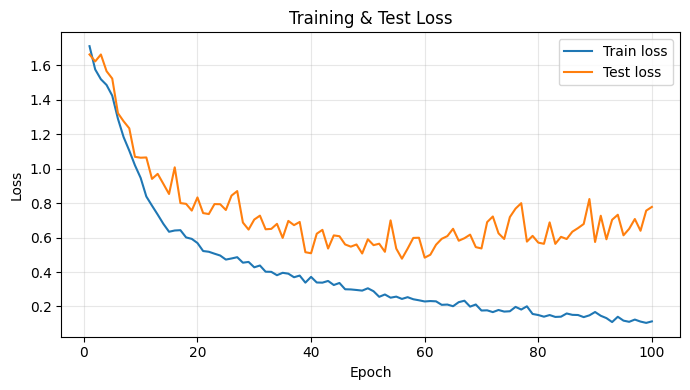

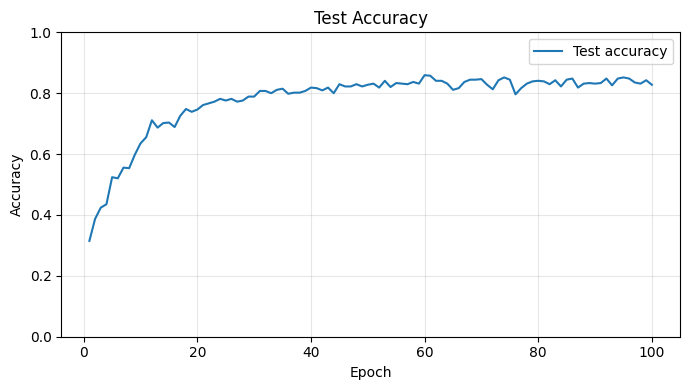

In [8]:
epochs = range(1, N_EPOCHS + 1)

# Plot training and test loss
plt.figure(figsize=(7,4))
plt.plot(epochs, train_loss_history, label='Train loss')
plt.plot(epochs, test_loss_history,  label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Test Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot test accuracy
plt.figure(figsize=(7,4))
plt.plot(epochs, test_acc_history, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# LOAD MODEL - if needed
# Make sure you define the same ViT model structure first
model = ViT(
    image_size=28,
    patch_size=4,
    num_classes=6,
    channels=1,
    dim=128,
    depth=10,
    heads=8,
    mlp_dim=256,
    dropout=0.1
)
model.to(device)

# Load saved weights
model.load_state_dict(torch.load('313605013.pth'))
model.eval()
print("✅ Model loaded and ready for testing")

✅ Model loaded and ready for testing


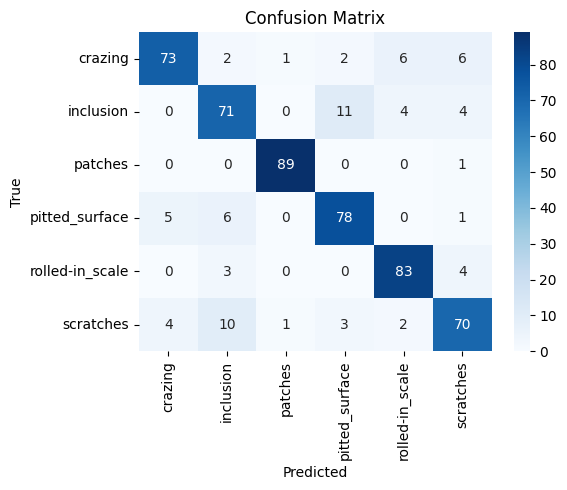

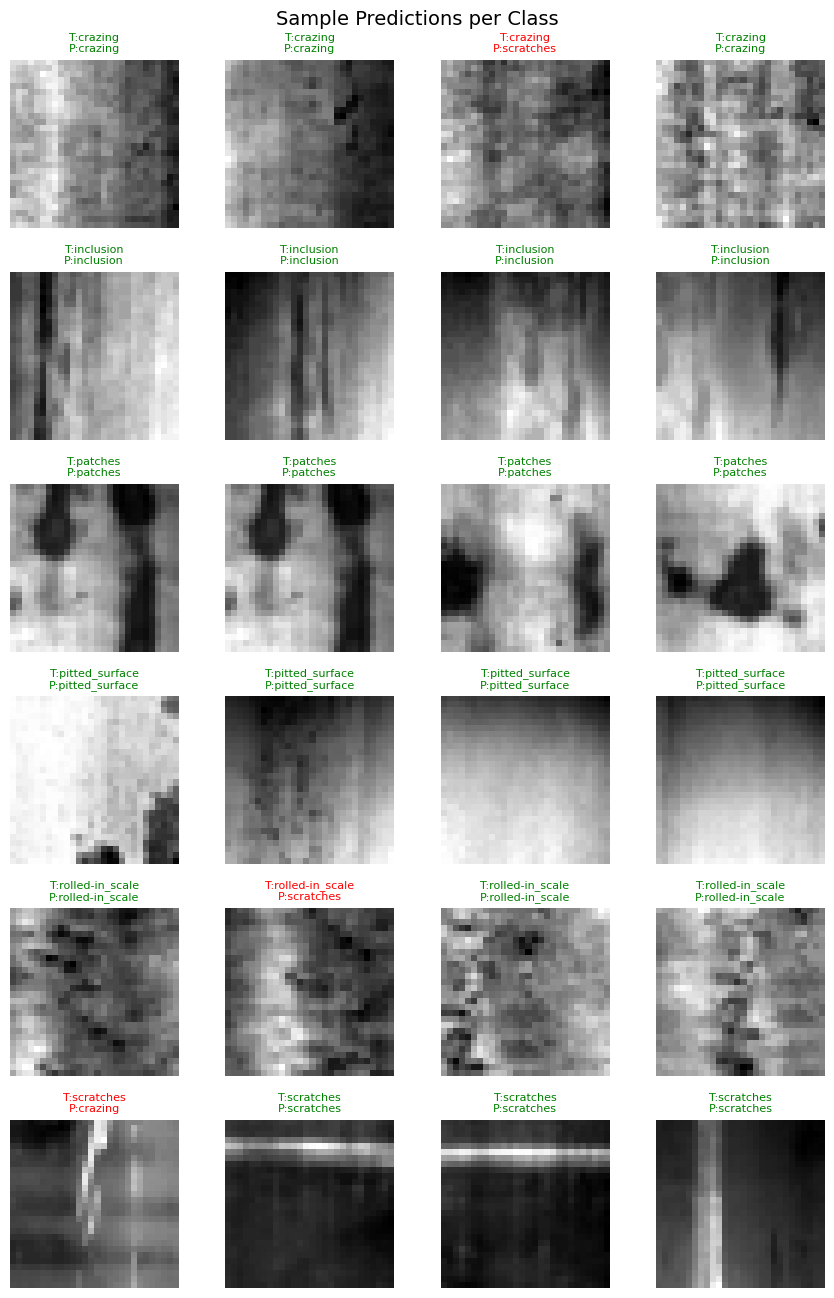

In [17]:
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === TODO: Define function to plot confusion matrix ===
def plot_confusion_matrix(model, data_loader, class_names):
    # HINT:
    # - Get predictions and true labels
    # - Compute confusion matrix (sklearn)
    # - Plot with seaborn heatmap
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.append(preds.cpu())
            all_labels.append(target.cpu())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# === TODO: Define function to plot example predictions ===
def plot_classwise_predictions(model, data_loader, class_names, samples_per_class=4):
    # HINT:
    # - Collect a few correct/incorrect predictions per class
    # - Plot grid of images with true vs predicted labels
    model.eval()
    collected = {cls: [] for cls in range(len(class_names))}

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)

            for img, label, pred in zip(data.cpu(), target.cpu(), preds.cpu()):
                cls = label.item()
                if len(collected[cls]) < samples_per_class:
                    collected[cls].append((img, label.item(), pred.item()))
                    
            if all(len(lst) >= samples_per_class for lst in collected.values()):
                break

    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=( samples_per_class * 2.2, n_classes * 2.2))
    
    for cls in range(n_classes):
        for k in range(samples_per_class):
            ax = axes[cls, k]
            img, true_lbl, pred_lbl = collected[cls][k]
            img = img.numpy() * 0.5 + 0.5
            ax.imshow(img.squeeze(), cmap='gray')
            title_color = 'green' if true_lbl == pred_lbl else 'red'
            ax.set_title(f'T:{class_names[true_lbl]}\nP:{class_names[pred_lbl]}', fontsize=8, color=title_color)
            ax.axis('off')

    plt.suptitle('Sample Predictions per Class', fontsize=14)
    plt.tight_layout()
    plt.show()

# === TODO: After training, call both functions ===
plot_confusion_matrix(model, test_loader, train_set.classes)
plot_classwise_predictions(model, test_loader, train_set.classes, samples_per_class=4)